In [78]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
import tensorflow as tf
import time

# Set display settings for visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.style.use('ggplot')

# Create directories for saving results
os.makedirs("results", exist_ok=True)
os.makedirs("trained_models", exist_ok=True)

def show_image(img, title="Image", figsize=(6, 6), save_path=None):
    """Utility function to display an image."""
    plt.figure(figsize=figsize)
    if len(img.shape) == 2 or img.shape[2] == 1:  # Grayscale
        plt.imshow(img, cmap='gray')
    else:  # Color
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    if save_path:
        plt.savefig(save_path)
    plt.show()

def load_and_preprocess_image(image_path, target_size=(224, 224), grayscale=False):
    """Load and preprocess an image for analysis."""
    if grayscale:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Could not read image: {image_path}")
            return None
        img = cv2.resize(img, target_size)
    else:
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if img is None:
            print(f"Could not read image: {image_path}")
            return None
        img = cv2.resize(img, target_size)
    
    return img

def get_golden_samples(golden_dir, count=5):
    """Get multiple golden samples for more robust reference comparison."""
    image_files = [f for f in os.listdir(golden_dir) if f.endswith(('.BMP', '.bmp', '.jpg', '.png', '.jpeg'))]
    
    if len(image_files) == 0:
        print(f"No image files found in {golden_dir}")
        return []
    
    # Select samples (either randomly or first N)
    selected_files = image_files[:min(count, len(image_files))]
    golden_samples = []
    
    for file in selected_files:
        img_path = os.path.join(golden_dir, file)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is not None:
            img = cv2.resize(img, (224, 224))
            golden_samples.append(img)
    
    print(f"Loaded {len(golden_samples)} golden samples")
    return golden_samples

Training dataset contains:
- Normal samples: 8
- Defect samples: 7


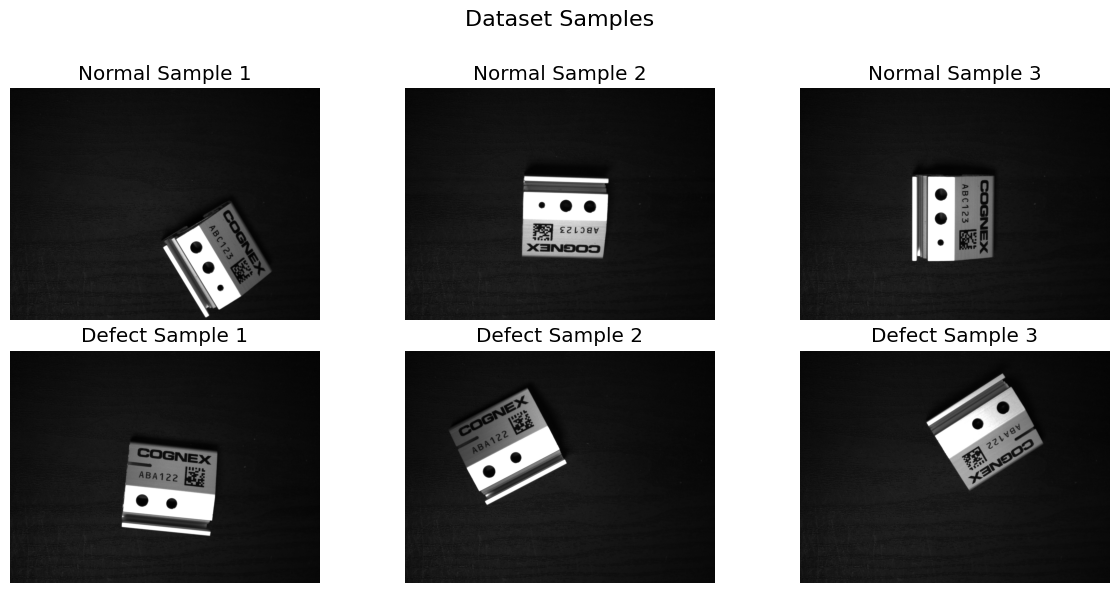

In [79]:
# Let's first examine our data
def explore_dataset(dataset_dir):
    """Explore the dataset structure and visualize some examples."""
    normal_train = os.path.join(dataset_dir, 'train', 'normal')
    defect_train = os.path.join(dataset_dir, 'train', 'defect')
    
    normal_files = [f for f in os.listdir(normal_train) if f.endswith(('.BMP', '.bmp', '.jpg', '.png'))]
    defect_files = [f for f in os.listdir(defect_train) if f.endswith(('.BMP', '.bmp', '.jpg', '.png'))]
    
    print(f"Training dataset contains:")
    print(f"- Normal samples: {len(normal_files)}")
    print(f"- Defect samples: {len(defect_files)}")
    
    # Visualize some examples
    plt.figure(figsize=(12, 6))
    for i in range(min(3, len(normal_files))):
        plt.subplot(2, 3, i+1)
        img = cv2.imread(os.path.join(normal_train, normal_files[i]))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Normal Sample {i+1}")
        plt.axis('off')
    
    for i in range(min(3, len(defect_files))):
        plt.subplot(2, 3, i+4)
        img = cv2.imread(os.path.join(defect_train, defect_files[i]))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Defect Sample {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle("Dataset Samples", fontsize=16)
    plt.subplots_adjust(top=0.85)
    plt.savefig("results/dataset_samples.png")
    plt.show()

# Explore the dataset
explore_dataset('defect_detection_dataset')

In [80]:
def enhance_image_for_defect_detection(img):
    """Apply image enhancements to better highlight potential defects."""
    # Convert to grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    # Apply slight Gaussian blur to reduce noise
    enhanced = cv2.GaussianBlur(enhanced, (5, 5), 0)
    
    return enhanced

def extract_features(img):
    """Extract relevant features for defect detection."""
    # Ensure grayscale
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 1. Edge detection (Canny)
    edges = cv2.Canny(img, 50, 150)
    
    # 2. Texture analysis using LBP (Local Binary Pattern)
    # For simplicity we'll use a basic implementation
    def local_binary_pattern(img):
        lbp = np.zeros_like(img)
        for i in range(1, img.shape[0]-1):
            for j in range(1, img.shape[1]-1):
                center = img[i, j]
                code = 0
                code |= (img[i-1, j-1] >= center) << 7
                code |= (img[i-1, j] >= center) << 6
                code |= (img[i-1, j+1] >= center) << 5
                code |= (img[i, j+1] >= center) << 4
                code |= (img[i+1, j+1] >= center) << 3
                code |= (img[i+1, j] >= center) << 2
                code |= (img[i+1, j-1] >= center) << 1
                code |= (img[i, j-1] >= center) << 0
                lbp[i, j] = code
        return lbp
    
    lbp = local_binary_pattern(img)
    
    # 3. Threshold for blob detection
    _, threshold = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    return {
        'edges': edges,
        'lbp': lbp,
        'threshold': threshold
    }

def improved_opencv_defect_classifier(image_path, golden_dir='defect_detection_dataset/train/normal', 
                                      threshold_multiplier=2.0, num_golden_samples=3, visualize=True):
    """Enhanced OpenCV-based defect classifier using multiple comparison techniques."""
    # Load and preprocess test image
    test_img = load_and_preprocess_image(image_path)
    if test_img is None:
        return False
    
    # Get golden samples
    golden_samples = get_golden_samples(golden_dir, count=num_golden_samples)
    if not golden_samples:
        print("No golden samples found.")
        return False
    
    # Initialize variables to store results
    all_diff_scores = []
    all_feature_scores = []
    
    # Process each golden sample for comparison
    for i, golden in enumerate(golden_samples):
        # 1. Basic image difference analysis
        enhanced_golden = enhance_image_for_defect_detection(golden)
        enhanced_test = enhance_image_for_defect_detection(test_img)
        
        # Calculate absolute difference
        diff = cv2.absdiff(enhanced_golden, enhanced_test)
        diff_score = np.sum(diff) / (diff.size * 255)  # Normalize to [0-1]
        all_diff_scores.append(diff_score)
        
        # 2. Feature-based comparison
        golden_features = extract_features(enhanced_golden)
        test_features = extract_features(enhanced_test)
        
        # Compare edges
        edge_diff = cv2.absdiff(golden_features['edges'], test_features['edges'])
        edge_score = np.sum(edge_diff) / (edge_diff.size * 255)
        
        # Compare LBP (texture)
        lbp_diff = cv2.absdiff(golden_features['lbp'], test_features['lbp'])
        lbp_score = np.sum(lbp_diff) / (lbp_diff.size * 255)
        
        # Compare thresholded images
        thresh_diff = cv2.absdiff(golden_features['threshold'], test_features['threshold'])
        thresh_score = np.sum(thresh_diff) / (thresh_diff.size * 255)
        
        # Combined feature score
        feature_score = (edge_score + lbp_score + thresh_score) / 3
        all_feature_scores.append(feature_score)
    
    # Calculate final scores (take median for robustness)
    final_diff_score = np.median(all_diff_scores)
    final_feature_score = np.median(all_feature_scores)
    
    # Combined score (weighted average)
    final_score = 0.4 * final_diff_score + 0.6 * final_feature_score
    
    # Dynamic threshold based on golden sample statistics
    # We use the threshold_multiplier to adjust sensitivity
    reference_scores = []
    for i, golden1 in enumerate(golden_samples):
        for j, golden2 in enumerate(golden_samples):
            if i < j:  # Compare each pair only once
                # Calculate difference and feature scores between golden samples
                enhanced_g1 = enhance_image_for_defect_detection(golden1)
                enhanced_g2 = enhance_image_for_defect_detection(golden2)
                diff = cv2.absdiff(enhanced_g1, enhanced_g2)
                diff_score = np.sum(diff) / (diff.size * 255)
                
                g1_features = extract_features(enhanced_g1)
                g2_features = extract_features(enhanced_g2)
                
                edge_diff = cv2.absdiff(g1_features['edges'], g2_features['edges'])
                edge_score = np.sum(edge_diff) / (edge_diff.size * 255)
                
                lbp_diff = cv2.absdiff(g1_features['lbp'], g2_features['lbp'])
                lbp_score = np.sum(lbp_diff) / (lbp_diff.size * 255)
                
                thresh_diff = cv2.absdiff(g1_features['threshold'], g2_features['threshold'])
                thresh_score = np.sum(thresh_diff) / (thresh_diff.size * 255)
                
                feature_score = (edge_score + lbp_score + thresh_score) / 3
                combined = 0.4 * diff_score + 0.6 * feature_score
                
                reference_scores.append(combined)
    
    if reference_scores:
        # Use median and std of golden-to-golden comparisons
        median_ref = np.median(reference_scores)
        std_ref = np.std(reference_scores)
        adaptive_threshold = median_ref + threshold_multiplier * std_ref
    else:
        # Fallback if not enough golden samples for comparison
        adaptive_threshold = 0.15  # Default threshold
    
    is_defective = final_score > adaptive_threshold
    
    if visualize:
        # Get first golden sample and test for visualization
        golden = golden_samples[0]
        
        enhanced_golden = enhance_image_for_defect_detection(golden)
        enhanced_test = enhance_image_for_defect_detection(test_img)
        
        diff = cv2.absdiff(enhanced_golden, enhanced_test)
        
        # Create a heatmap visualization
        heatmap = cv2.applyColorMap(diff, cv2.COLORMAP_JET)
        
        # Overlay heatmap on original image (with transparency)
        overlay = test_img.copy()
        overlay_weight = 0.7
        test_vis = cv2.addWeighted(heatmap, overlay_weight, test_img, 1-overlay_weight, 0)
        
        # Display results
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 3, 1)
        plt.imshow(cv2.cvtColor(golden, cv2.COLOR_BGR2RGB))
        plt.title('Golden Sample')
        plt.axis('off')
        
        plt.subplot(2, 3, 2)
        plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
        plt.title('Test Image')
        plt.axis('off')
        
        plt.subplot(2, 3, 3)
        plt.imshow(diff, cmap='gray')
        plt.title('Difference')
        plt.axis('off')
        
        plt.subplot(2, 3, 4)
        plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))
        plt.title('Difference Heatmap')
        plt.axis('off')
        
        plt.subplot(2, 3, 5)
        plt.imshow(cv2.cvtColor(test_vis, cv2.COLOR_BGR2RGB))
        plt.title(f'Defect Overlay (Score: {final_score:.4f})')
        plt.axis('off')
        
        test_features = extract_features(enhanced_test)
        plt.subplot(2, 3, 6)
        plt.imshow(test_features['edges'], cmap='gray')
        plt.title('Edge Features')
        plt.axis('off')
        
        plt.suptitle(f"Defective: {is_defective} (Threshold: {adaptive_threshold:.4f})", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        
        # Save visualization
        plt.savefig(f"results/opencv_defect_analysis_{os.path.basename(image_path)}.png")
        plt.show()
    
    return is_defective, final_score, adaptive_threshold

In [81]:
def ensemble_opencv_defect_detector(image_path, golden_dir='defect_detection_dataset/train/normal', visualize=False):
    """Ensemble of multiple OpenCV-based defect detection methods."""
    # Method 1: Enhanced basic difference detection
    basic_method = improved_opencv_defect_classifier(
        image_path, golden_dir, threshold_multiplier=2.0, visualize=False)
    
    # Method 2: Texture-based analysis
    def texture_analysis(image_path, golden_dir):
        # Load images
        test_img = load_and_preprocess_image(image_path, grayscale=True)
        golden_samples = get_golden_samples(golden_dir, count=3)
        golden_grays = [cv2.cvtColor(g, cv2.COLOR_BGR2GRAY) for g in golden_samples]
        
        # Perform GLCM (Gray-Level Co-occurrence Matrix) analysis
        from skimage.feature import graycomatrix, graycoprops
        
        def get_glcm_features(img):
            # Quantize to fewer gray levels
            bins = 16
            quantized = np.uint8(np.floor(img / (256 / bins)) * (256 / bins))
            
            # Calculate GLCM
            glcm = graycomatrix(quantized, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=bins, symmetric=True, normed=True)
            
            # Extract features
            contrast = graycoprops(glcm, 'contrast')
            dissimilarity = graycoprops(glcm, 'dissimilarity')
            homogeneity = graycoprops(glcm, 'homogeneity')
            energy = graycoprops(glcm, 'energy')
            correlation = graycoprops(glcm, 'correlation')
            
            # Average over all directions
            features = {
                'contrast': np.mean(contrast),
                'dissimilarity': np.mean(dissimilarity),
                'homogeneity': np.mean(homogeneity),
                'energy': np.mean(energy),
                'correlation': np.mean(correlation)
            }
            return features
        
        # Get features for test image
        test_features = get_glcm_features(test_img)
        
        # Get features for golden samples
        golden_features = [get_glcm_features(g) for g in golden_grays]
        
        # Calculate average feature values from golden samples
        avg_golden_features = {}
        for feature in golden_features[0].keys():
            avg_golden_features[feature] = np.mean([g[feature] for g in golden_features])
        
        # Calculate difference scores
        diff_scores = {}
        for feature in test_features.keys():
            norm_factor = max(avg_golden_features[feature], 0.0001)  # Avoid division by zero
            diff_scores[feature] = abs(test_features[feature] - avg_golden_features[feature]) / norm_factor
        
        # Calculate final texture score (weighted average)
        weights = {
            'contrast': 0.25,
            'dissimilarity': 0.25,
            'homogeneity': 0.2,
            'energy': 0.2,
            'correlation': 0.1
        }
        
        texture_score = sum(diff_scores[f] * weights[f] for f in diff_scores)
        
        # Threshold based on texture analysis
        texture_threshold = 0.3  # This should be tuned based on your specific dataset
        is_defective = texture_score > texture_threshold
        
        return is_defective, texture_score, texture_threshold
    
    try:
        texture_method = texture_analysis(image_path, golden_dir)
    except:
        # Fallback if texture analysis fails
        texture_method = (basic_method[0], basic_method[1], basic_method[2])
    
    # Method 3: Edge and contour analysis
    def edge_contour_analysis(image_path, golden_dir):
        # Load images
        test_img = load_and_preprocess_image(image_path)
        golden_samples = get_golden_samples(golden_dir, count=1)
        
        if not golden_samples:
            return False, 0, 0
        
        golden = golden_samples[0]
        
        # Extract edges
        test_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
        golden_gray = cv2.cvtColor(golden, cv2.COLOR_BGR2GRAY)
        
        test_edges = cv2.Canny(test_gray, 50, 150)
        golden_edges = cv2.Canny(golden_gray, 50, 150)
        
        # Find contours
        test_contours, _ = cv2.findContours(test_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        golden_contours, _ = cv2.findContours(golden_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Compare number of contours and their areas
        test_areas = [cv2.contourArea(c) for c in test_contours]
        golden_areas = [cv2.contourArea(c) for c in golden_contours]
        
        test_contour_count = len(test_contours)
        golden_contour_count = len(golden_contours)
        
        # Calculate mean and std of contour areas
        test_mean_area = np.mean(test_areas) if test_areas else 0
        golden_mean_area = np.mean(golden_areas) if golden_areas else 0
        
        # Calculate difference score
        count_diff = abs(test_contour_count - golden_contour_count) / max(golden_contour_count, 1)
        area_diff = abs(test_mean_area - golden_mean_area) / max(golden_mean_area, 1)
        
        edge_score = 0.5 * count_diff + 0.5 * area_diff
        edge_threshold = 0.4  # This should be tuned
        
        is_defective = edge_score > edge_threshold
        
        return is_defective, edge_score, edge_threshold
    
    edge_method = edge_contour_analysis(image_path, golden_dir)
    
    # Combine results with weighted voting
    methods = [
        ("Basic Difference", basic_method[0], basic_method[1], 0.4),
        ("Texture Analysis", texture_method[0], texture_method[1], 0.4),
        ("Edge Analysis", edge_method[0], edge_method[1], 0.2)
    ]
    
    # Calculate weighted score
    weighted_score = sum(method[2] * method[3] for method in methods)
    
    # Weighted voting for final decision
    weighted_votes = sum(int(method[1]) * method[3] for method in methods)
    final_decision = weighted_votes > 0.5
    
    if visualize:
        # Visualize ensemble results
        plt.figure(figsize=(10, 6))
        
        # Plot individual method scores
        methods_names = [m[0] for m in methods]
        methods_scores = [m[2] for m in methods]
        methods_thresholds = [basic_method[2], texture_method[2], edge_method[2]]
        
        plt.bar(methods_names, methods_scores, alpha=0.7, color='skyblue')
        
        # Add threshold lines
        for i, threshold in enumerate(methods_thresholds):
            plt.plot([i-0.4, i+0.4], [threshold, threshold], 'r--', linewidth=2)
            
        plt.axhline(y=0.5, color='green', linestyle='--', linewidth=2, label='Ensemble Threshold')
        
        plt.xlabel('Method')
        plt.ylabel('Score')
        plt.title(f'Ensemble Detection Results - Final: {"Defective" if final_decision else "Normal"}')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"results/ensemble_results_{os.path.basename(image_path)}.png")
        plt.show()
        
        # Load and display the original image with verdict
        test_img = load_and_preprocess_image(image_path)
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
        
        # Add colored border based on verdict
        if final_decision:
            plt.gca().add_patch(plt.Rectangle((0, 0), test_img.shape[1], test_img.shape[0], 
                                             linewidth=10, edgecolor='red', facecolor='none'))
            plt.title(f"DEFECTIVE (Score: {weighted_score:.4f})")
        else:
            plt.gca().add_patch(plt.Rectangle((0, 0), test_img.shape[1], test_img.shape[0], 
                                             linewidth=10, edgecolor='green', facecolor='none'))
            plt.title(f"NORMAL (Score: {weighted_score:.4f})")
        
        plt.axis('off')
        plt.savefig(f"results/ensemble_verdict_{os.path.basename(image_path)}.png")
        plt.show()
    
    return final_decision, weighted_score

In [83]:
def prepare_data_for_yolo(dataset_dir, output_dir="yolo_data"):
    """Prepare data in the right format for YOLO training."""
    # Create directories
    os.makedirs(f"{output_dir}/images/train", exist_ok=True)
    os.makedirs(f"{output_dir}/images/val", exist_ok=True)
    os.makedirs(f"{output_dir}/labels/train", exist_ok=True)
    os.makedirs(f"{output_dir}/labels/val", exist_ok=True)
    
    # Get source directories
    train_normal_dir = os.path.join(dataset_dir, 'train/normal')
    train_defect_dir = os.path.join(dataset_dir, 'train/defect')
    val_normal_dir = os.path.join(dataset_dir, 'validation/normal')
    val_defect_dir = os.path.join(dataset_dir, 'validation/defect')
    
    # Process normal samples (class 0)
    for split, src_dir, dst_img_dir, dst_label_dir in [
        ('train', train_normal_dir, f"{output_dir}/images/train", f"{output_dir}/labels/train"),
        ('val', val_normal_dir, f"{output_dir}/images/val", f"{output_dir}/labels/val")
    ]:
        for img_file in os.listdir(src_dir):
            if img_file.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.BMP')):
                # Copy image
                src_path = os.path.join(src_dir, img_file)
                dst_img_path = os.path.join(dst_img_dir, f"{os.path.splitext(img_file)[0]}.jpg")
                
                # Create label file (YOLO format)
                # For normal samples, we create an empty label file (no defects)
                label_path = os.path.join(dst_label_dir, f"{os.path.splitext(img_file)[0]}.txt")
                
                # Convert the image to jpg if needed and save
                img = cv2.imread(src_path)
                if img is not None:
                    cv2.imwrite(dst_img_path, img)
                    # Create empty label file
                    with open(label_path, 'w') as f:
                        pass
    
    # Process defect samples (class 1)
    for split, src_dir, dst_img_dir, dst_label_dir in [
        ('train', train_defect_dir, f"{output_dir}/images/train", f"{output_dir}/labels/train"),
        ('val', val_defect_dir, f"{output_dir}/images/val", f"{output_dir}/labels/val")
    ]:
        for img_file in os.listdir(src_dir):
            if img_file.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.BMP')):
                # Copy image
                src_path = os.path.join(src_dir, img_file)
                dst_img_path = os.path.join(dst_img_dir, f"{os.path.splitext(img_file)[0]}.jpg")
                
                # Create label file (YOLO format)
                # For defect samples, we create a label covering most of the image
                label_path = os.path.join(dst_label_dir, f"{os.path.splitext(img_file)[0]}.txt")
                
                # Convert the image to jpg if needed and save
                img = cv2.imread(src_path)
                if img is not None:
                    cv2.imwrite(dst_img_path, img)
                    # Create label file with one defect covering most of the image
                    # Format: <class> <x_center> <y_center> <width> <height>
                    with open(label_path, 'w') as f:
                        f.write("0 0.5 0.5 0.9 0.9\n")  # Class 0 for 'defect'
    
    # Create dataset.yaml file for YOLO
    yaml_content = f"""
# YOLOv8 configuration file
path: {os.path.abspath(output_dir)}
train: images/train
val: images/val
test: images/val

# Classes
names:
  0: defect
"""
    
    with open(f"{output_dir}/dataset.yaml", 'w') as f:
        f.write(yaml_content)
    
    print(f"Data prepared for YOLO in {output_dir}")
    print(f"Use the following YAML file for training: {output_dir}/dataset.yaml")
    
    return f"{output_dir}/dataset.yaml"

def train_yolo_model(yaml_path, model_size='n', epochs=50):
    """Train a YOLOv8 model for defect detection."""
    from ultralytics import YOLO
    
    # Load a pre-trained YOLOv8 model
    model = YOLO(f'yolov8{model_size}.pt')
    
    # Train the model
    results = model.train(
        data=yaml_path,
        epochs=epochs,
        imgsz=640,
        batch=16,
        name='defect_detector',
        project='trained_models',
        patience=10  # Early stopping
    )
    
    return results

def yolo_defect_detector(image_path, model_path='trained_models/defect_detector/weights/best.pt', 
                         conf_threshold=0.25, visualize=True):
    """Detect defects using a trained YOLOv8 model."""
    from ultralytics import YOLO
    
    # Load model
    model = YOLO(model_path)
    
    # Run inference
    results = model(image_path, conf=conf_threshold)[0]
    
    # Process results
    is_defective = len(results.boxes) > 0  # If any defects are detected
    
    # Get maximum confidence score if defects detected
    confidence = 0
    if is_defective:
        confidence = float(results.boxes.conf.max().item())
    
    if visualize:
        # Visualize detection
        result_img = results.plot()
        
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        plt.title(f"YOLO Detection: {'Defective' if is_defective else 'Normal'} (Conf: {confidence:.4f})")
        plt.axis('off')
        plt.savefig(f"results/yolo_detection_{os.path.basename(image_path)}.png")
        plt.show()
    
    return is_defective, confidence

In [84]:
def setup_anomalib():
    """Set up anomalib for anomaly detection."""
    try:
        import anomalib
        print(f"Anomalib version {anomalib.__version__} is already installed.")
    except ImportError:
        print("Installing anomalib...")
        os.system("pip install anomalib")
        import anomalib
        print(f"Anomalib version {anomalib.__version__} installed.")

def prepare_data_for_anomalib(dataset_dir, output_dir="anomalib_data"):
    """Prepare data in the right format for anomalib training."""
    # Create directory structure
    os.makedirs(f"{output_dir}/train/good", exist_ok=True)
    os.makedirs(f"{output_dir}/test/good", exist_ok=True)
    os.makedirs(f"{output_dir}/test/defect", exist_ok=True)
    
    # Get source directories
    train_normal_dir = os.path.join(dataset_dir, 'train/normal')
    test_normal_dir = os.path.join(dataset_dir, 'test/normal')
    test_defect_dir = os.path.join(dataset_dir, 'test/defect')
    
    # Copy training normal samples
    for file in os.listdir(train_normal_dir):
        if file.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.BMP')):
            src_path = os.path.join(train_normal_dir, file)
            dst_path = os.path.join(f"{output_dir}/train/good", file)
            shutil.copy2(src_path, dst_path)
    
    # Copy test normal samples
    for file in os.listdir(test_normal_dir):
        if file.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.BMP')):
            src_path = os.path.join(test_normal_dir, file)
            dst_path = os.path.join(f"{output_dir}/test/good", file)
            shutil.copy2(src_path, dst_path)
    
    # Copy test defect samples
    for file in os.listdir(test_defect_dir):
        if file.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.BMP')):
            src_path = os.path.join(test_defect_dir, file)
            dst_path = os.path.join(f"{output_dir}/test/defect", file)
            shutil.copy2(src_path, dst_path)
    
    print(f"Data prepared for anomalib in {output_dir}")
    
    return output_dir

def train_anomalib_model(data_path, method="patchcore", image_size=256, batch_size=16):
    """Train an anomaly detection model using anomalib."""
    import anomalib
    from anomalib.data import MVTec
    from anomalib.models import get_model
    from anomalib.engine import Engine
    
    # Configure the model
    model_config = anomalib.config.get_configurable_parameters(
        model_name=method,
        dataset_path=data_path,
        image_size=(image_size, image_size)
    )
    
    # Configure the datamodule
    model_config.dataset.category = "demo_block"  # Just a name for the category
    model_config.dataset.task_type = "segmentation"
    model_config.dataset.train_batch_size = batch_size
    model_config.dataset.eval_batch_size = batch_size
    model_config.dataset.num_workers = 4
    
    # Create datamodule
    datamodule = MVTec(
        root=data_path,
        category="demo_block",
        image_size=(image_size, image_size),
        train_batch_size=batch_size,
        eval_batch_size=batch_size,
        num_workers=4,
        task="segmentation"
    )
    
    # Create model and engine
    model = get_model(model_config)
    engine = Engine(model=model, datamodule=datamodule)
    
    # Train the model
    engine.fit()
    
    # Test the model
    engine.test()
    
    # Save model path for future use
    model_path = os.path.join(engine.trainer.log_dir, "weights/model.ckpt")
    print(f"Model saved to: {model_path}")
    
    return engine, model_path

def anomalib_defect_detector(image_path, engine, threshold=None, visualize=True):
    """Detect defects using a trained anomalib model."""
    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Run prediction
    predictions = engine.predict(img)
    
    # Get anomaly score and mask
    anomaly_score = predictions.pred_score
    anomaly_map = predictions.pred_mask
    
    # If threshold not provided, use the one computed during model validation
    if threshold is None:
        threshold = engine.model.image_threshold.value
    
    is_defective = anomaly_score > threshold
    
    if visualize:
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(anomaly_map, cmap='jet')
        plt.title(f"Anomaly Map (Score: {anomaly_score:.4f})")
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        # Overlay anomaly map on original image
        overlay = img.copy()
        alpha = 0.5
        if len(anomaly_map.shape) == 2:
            # Convert to heatmap
            anomaly_map_norm = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min() + 1e-8)
            heatmap = (anomaly_map_norm * 255).astype(np.uint8)
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
            
            # Overlay
            overlay = cv2.addWeighted(overlay, 1-alpha, heatmap, alpha, 0)
        
        plt.imshow(overlay)
        plt.title(f"Defective: {is_defective}")
        plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(f"results/anomalib_detection_{os.path.basename(image_path)}.png")
        plt.show()
    
    return is_defective, anomaly_score, threshold

In [85]:
def compare_performance(methods, test_dir):
    """Compare performance of different defect detection methods."""
    # Get test images
    normal_dir = os.path.join(test_dir, 'normal')
    defect_dir = os.path.join(test_dir, 'defect')
    
    normal_imgs = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir) 
                  if f.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.BMP'))]
    defect_imgs = [os.path.join(defect_dir, f) for f in os.listdir(defect_dir)
                  if f.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.BMP'))]
    
    # Limit the number of images for quicker evaluation
    max_images = 20
    normal_imgs = normal_imgs[:min(max_images, len(normal_imgs))]
    defect_imgs = defect_imgs[:min(max_images, len(defect_imgs))]
    
    # For timing
    method_times = {}
    
    # For metrics
    method_results = {}
    
    # Loop through methods
    for method_name, detector_fn in methods.items():
        print(f"\nEvaluating method: {method_name}")
        
        y_true = []
        y_pred = []
        y_scores = []
        runtimes = []
        
        # Process normal images
        for img_path in normal_imgs:
            start_time = time.time()
            result = detector_fn(img_path, visualize=False)
            end_time = time.time()
            
            is_defective = result[0]
            score = result[1]
            
            y_true.append(0)  # 0 for normal
            y_pred.append(1 if is_defective else 0)
            y_scores.append(score)
            runtimes.append(end_time - start_time)
        
        # Process defect images
        for img_path in defect_imgs:
            start_time = time.time()
            result = detector_fn(img_path, visualize=False)
            end_time = time.time()
            
            is_defective = result[0]
            score = result[1]
            
            y_true.append(1)  # 1 for defect
            y_pred.append(1 if is_defective else 0)
            y_scores.append(score)
            runtimes.append(end_time - start_time)
        
        # Calculate metrics
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
        
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        avg_time = np.mean(runtimes)
        
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        
        # Calculate PR curve
        precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = auc(recall_curve, precision_curve)
        
        # Save results
        method_results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'fpr': fpr,
            'tpr': tpr,
            'precision_curve': precision_curve,
            'recall_curve': recall_curve,
            'avg_runtime': avg_time
        }
        
        method_times[method_name] = avg_time
        
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print(f"  ROC AUC: {roc_auc:.4f}")
        print(f"  PR AUC: {pr_auc:.4f}")
        print(f"  Avg. Runtime: {avg_time:.4f} seconds")
    
    # Plot comparison charts
    # 1. Bar chart of metrics
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']
    method_names = list(methods.keys())
    
    plt.figure(figsize=(15, 10))
    
    width = 0.15
    x = np.arange(len(method_names))
    
    for i, metric in enumerate(metrics):
        values = [method_results[m][metric] for m in method_names]
        plt.bar(x + i*width, values, width, label=metric)
    
    plt.xlabel('Method')
    plt.ylabel('Score')
    plt.title('Performance Comparison of Defect Detection Methods')
    plt.xticks(x + width * (len(metrics) - 1) / 2, method_names, rotation=45)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig('results/performance_comparison_metrics.png')
    plt.show()
    
    # 2. Runtime comparison
    plt.figure(figsize=(10, 6))
    plt.bar(method_names, [method_times[m] for m in method_names], color='skyblue')
    plt.xlabel('Method')
    plt.ylabel('Avg. Runtime (seconds)')
    plt.title('Average Runtime Comparison')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig('results/performance_comparison_runtime.png')
    plt.show()
    
    # 3. ROC curve comparison
    plt.figure(figsize=(10, 8))
    for method_name in method_names:
        plt.plot(method_results[method_name]['fpr'], 
                 method_results[method_name]['tpr'], 
                 label=f"{method_name} (AUC = {method_results[method_name]['roc_auc']:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('results/performance_comparison_roc.png')
    plt.show()
    
    # 4. PR curve comparison
    plt.figure(figsize=(10, 8))
    for method_name in method_names:
        plt.plot(method_results[method_name]['recall_curve'], 
                 method_results[method_name]['precision_curve'], 
                 label=f"{method_name} (AUC = {method_results[method_name]['pr_auc']:.2f})")
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve Comparison')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('results/performance_comparison_pr.png')
    plt.show()
    
    return method_results

Training dataset contains:
- Normal samples: 8
- Defect samples: 7


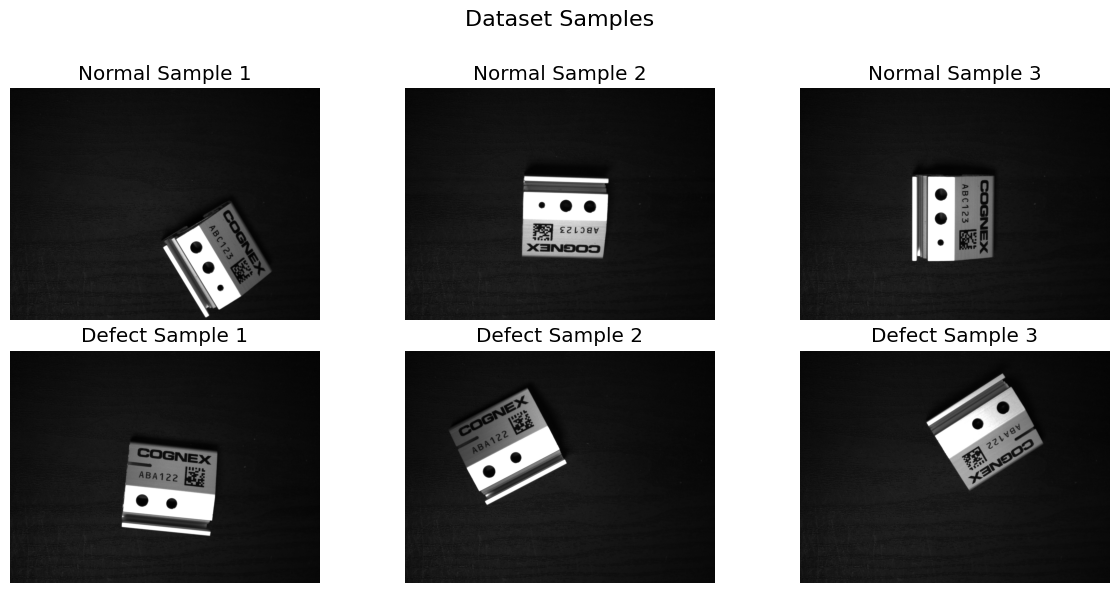

Loaded 3 golden samples


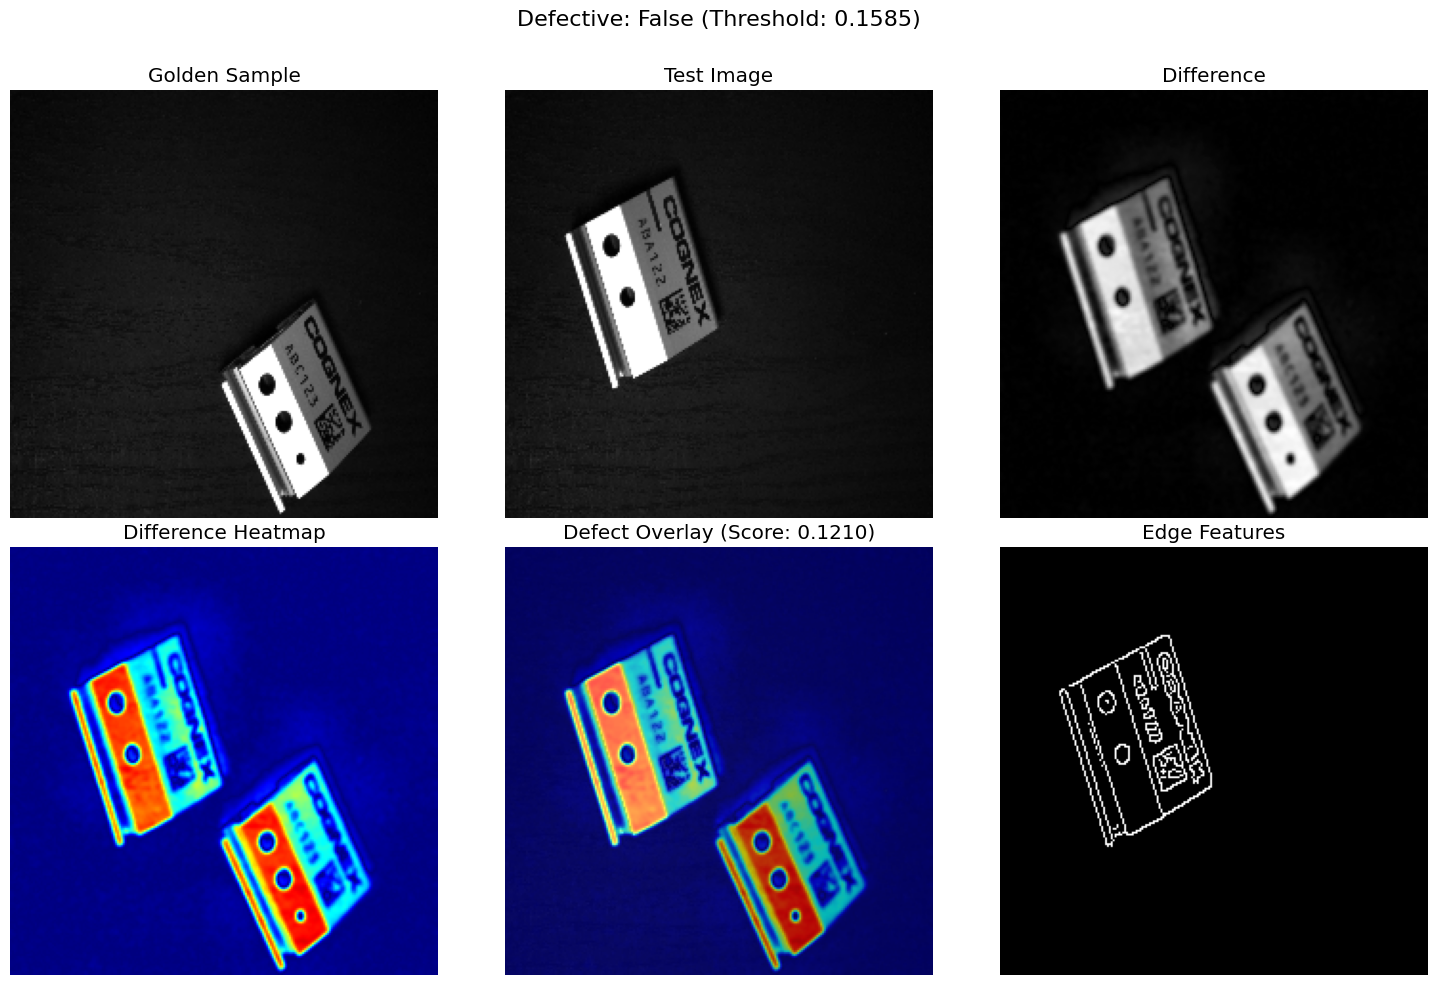

Defective? False (Score: 0.1210, Threshold: 0.1585)
Loaded 3 golden samples


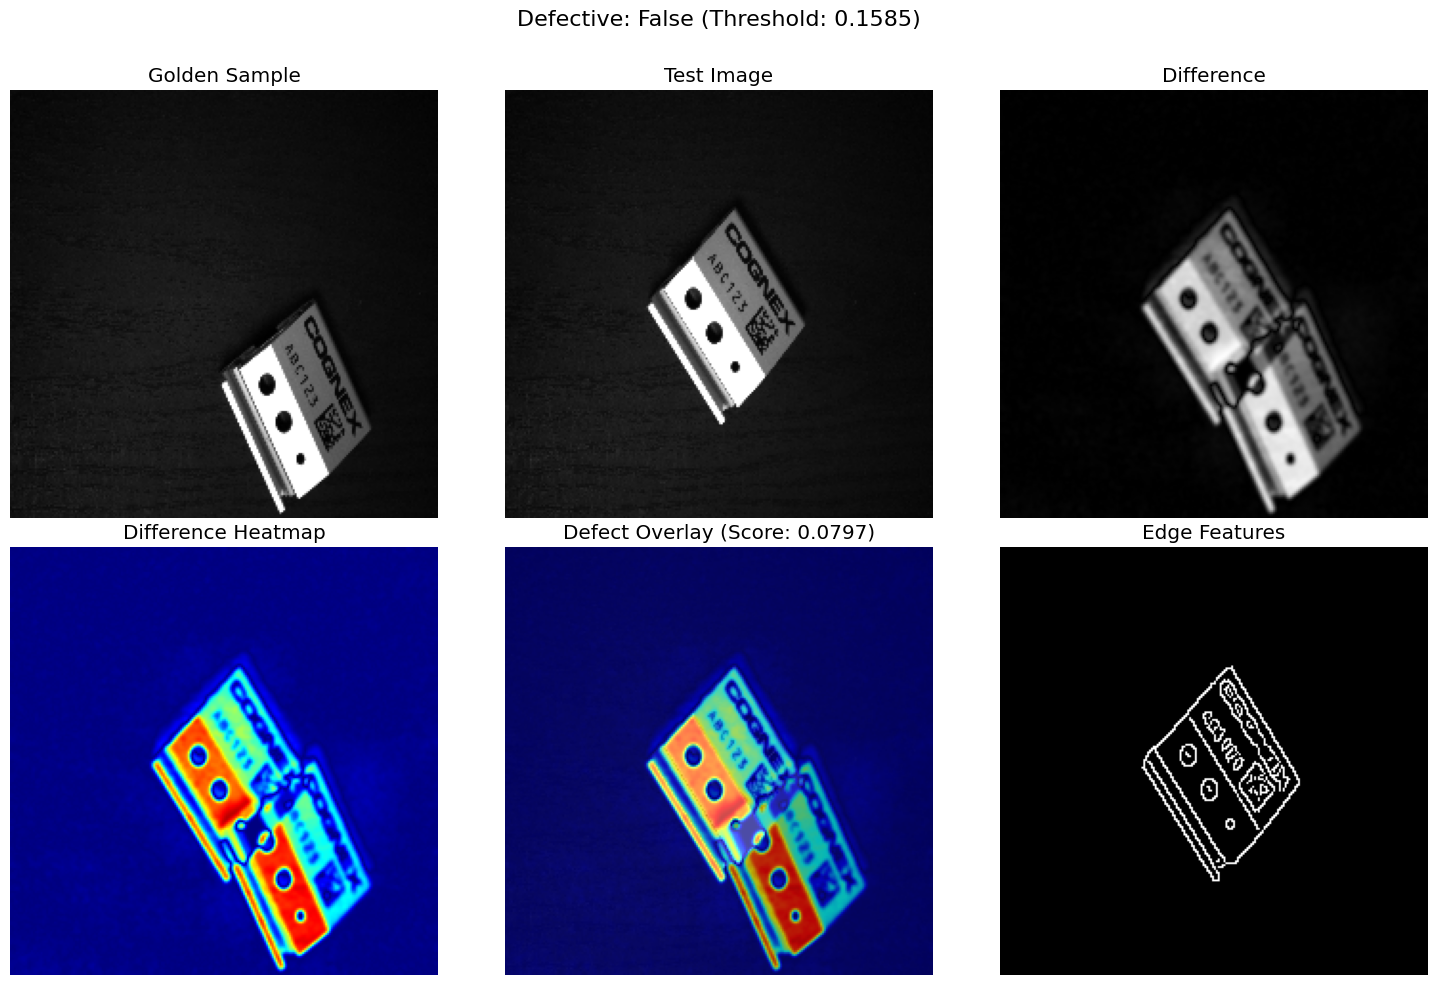

Defective? False (Score: 0.0797, Threshold: 0.1585)
Loaded 3 golden samples
Loaded 3 golden samples
Loaded 1 golden samples


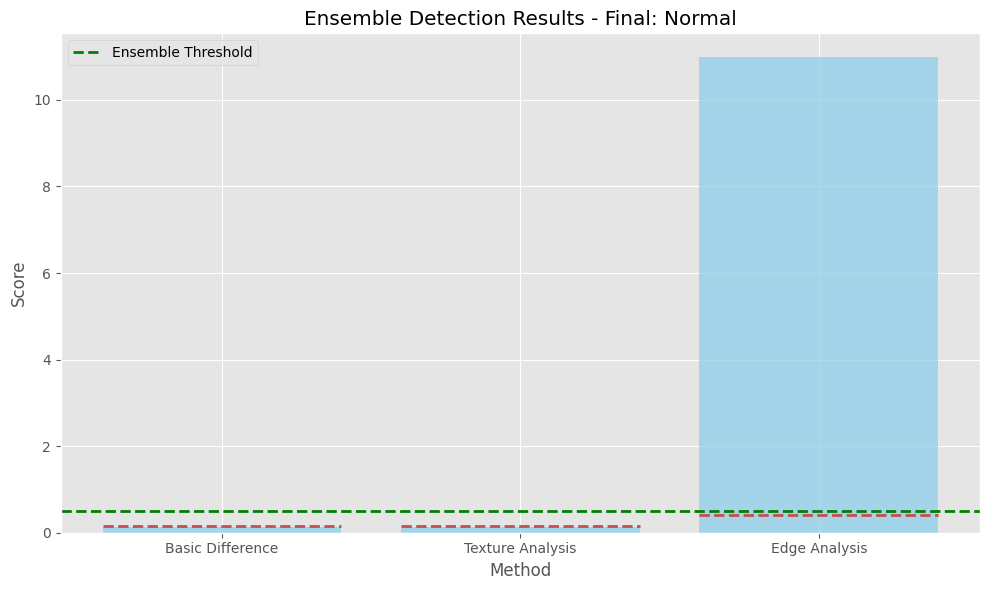

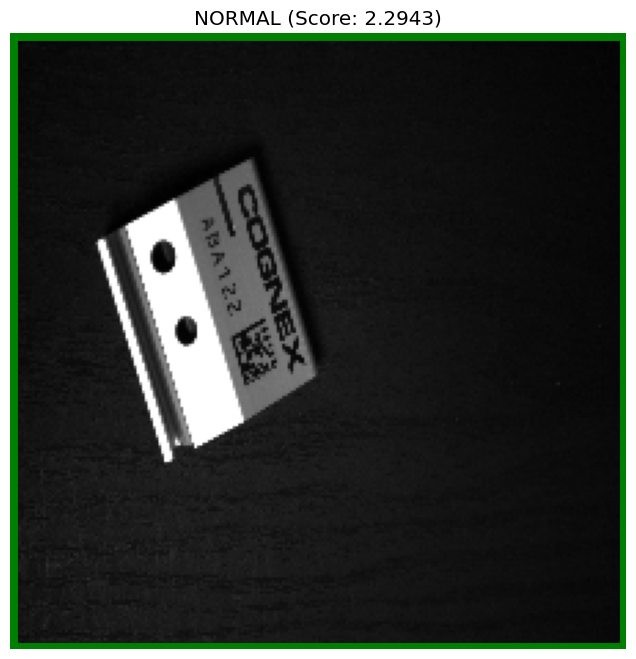

Ensemble detector - Defective? False (Score: 2.2943)
Loaded 3 golden samples
Loaded 3 golden samples
Loaded 1 golden samples


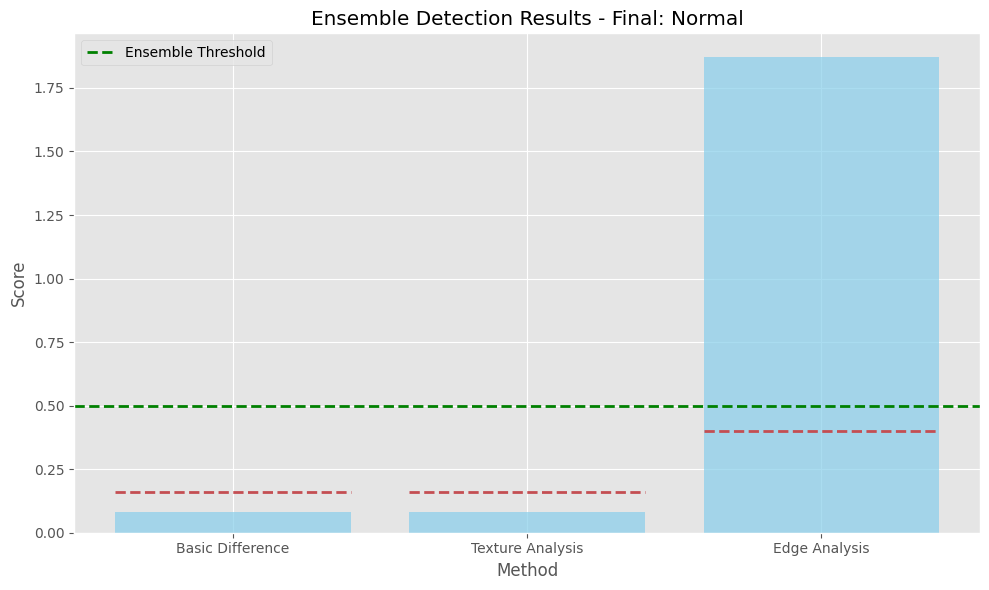

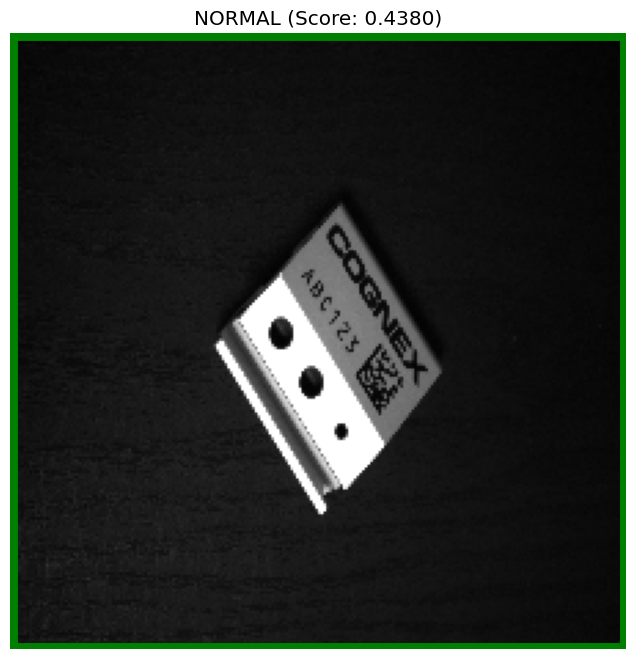

Ensemble detector - Defective? False (Score: 0.4380)
Data prepared for YOLO in yolo_data
Use the following YAML file for training: yolo_data/dataset.yaml
Prepared YOLO training data. Would you like to train the YOLO model? (This can take time)
Training YOLO model...
Ultralytics 8.3.131 🚀 Python-3.12.10 torch-2.7.0 CPU (Apple M1 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_data/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, m

train: Scanning /Users/ducle/Library/CloudStorage/OneDrive-RMITUniversity/Courses/OENG1183 - Capstone A/abb-capstone/yolo_data/labels/train.cache... 15 images, 8 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 749.5±298.4 MB/s, size: 390.1 KB)



val: Scanning /Users/ducle/Library/CloudStorage/OneDrive-RMITUniversity/Courses/OENG1183 - Capstone A/abb-capstone/yolo_data/labels/val.cache... 2 images, 1 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<?, ?it/s]

Plotting labels to trained_models/defect_detector2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to trained_models/defect_detector2
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.756      5.573      2.401          7        640: 100%|██████████| 1/1 [00:04<00:00,  4.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

                   all          2          1    0.00167          1      0.142     0.0995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.475      5.198      1.984          7        640: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]

                   all          2          1    0.00167          1      0.142     0.0995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.299       5.34      2.005          7        640: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

                   all          2          1    0.00167          1      0.142      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.311       5.15      2.152          7        640: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

                   all          2          1    0.00167          1      0.166      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.075      4.732      1.998          7        640: 100%|██████████| 1/1 [00:03<00:00,  3.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]

                   all          2          1    0.00167          1      0.249      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G     0.8927      4.157       1.61          7        640: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all          2          1    0.00167          1      0.332      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/10         0G     0.6959      4.059      1.656          7        640: 100%|██████████| 1/1 [00:03<00:00,  3.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]

                   all          2          1    0.00167          1      0.497      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G     0.7529      4.036      1.716          7        640: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all          2          1    0.00167          1      0.497      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G     0.7367      4.134      1.633          7        640: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]

                   all          2          1    0.00167          1      0.497      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.7947      4.076      1.626          7        640: 100%|██████████| 1/1 [00:04<00:00,  4.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]

                   all          2          1    0.00167          1      0.497      0.348



10 epochs completed in 0.011 hours.
Optimizer stripped from trained_models/defect_detector2/weights/last.pt, 6.2MB
Optimizer stripped from trained_models/defect_detector2/weights/best.pt, 6.2MB

Validating trained_models/defect_detector2/weights/best.pt...
Ultralytics 8.3.131 🚀 Python-3.12.10 torch-2.7.0 CPU (Apple M1 Pro)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


                   all          2          1    0.00167          1      0.497      0.348
Speed: 0.5ms preprocess, 59.6ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to trained_models/defect_detector2

image 1/1 /Users/ducle/Library/CloudStorage/OneDrive-RMITUniversity/Courses/OENG1183 - Capstone A/abb-capstone/defect_detection_dataset/test/defect/Demo Block (18).BMP: 480x640 (no detections), 56.6ms
Speed: 1.8ms preprocess, 56.6ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)


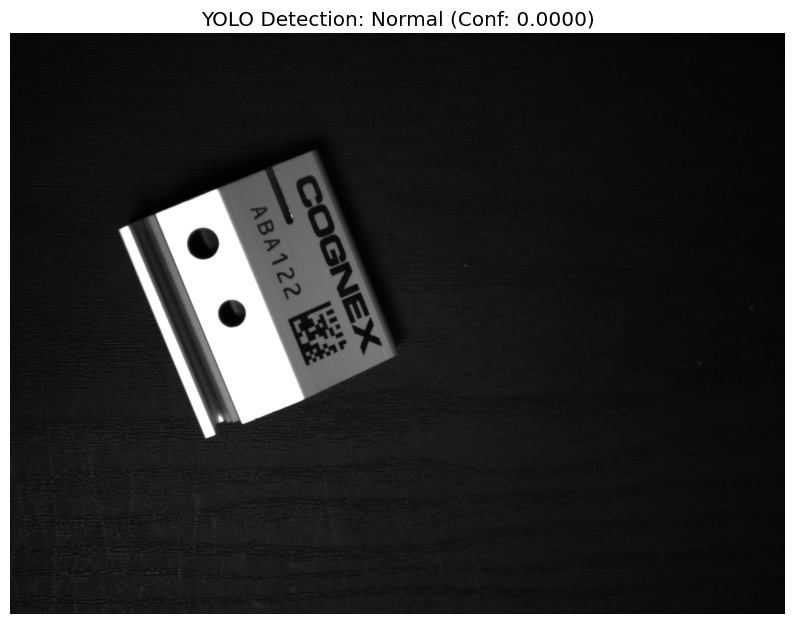

YOLO detector - Defective? False (Confidence: 0.0000)

image 1/1 /Users/ducle/Library/CloudStorage/OneDrive-RMITUniversity/Courses/OENG1183 - Capstone A/abb-capstone/defect_detection_dataset/test/normal/Demo Block (13).BMP: 480x640 (no detections), 57.1ms
Speed: 2.0ms preprocess, 57.1ms inference, 0.2ms postprocess per image at shape (1, 3, 480, 640)


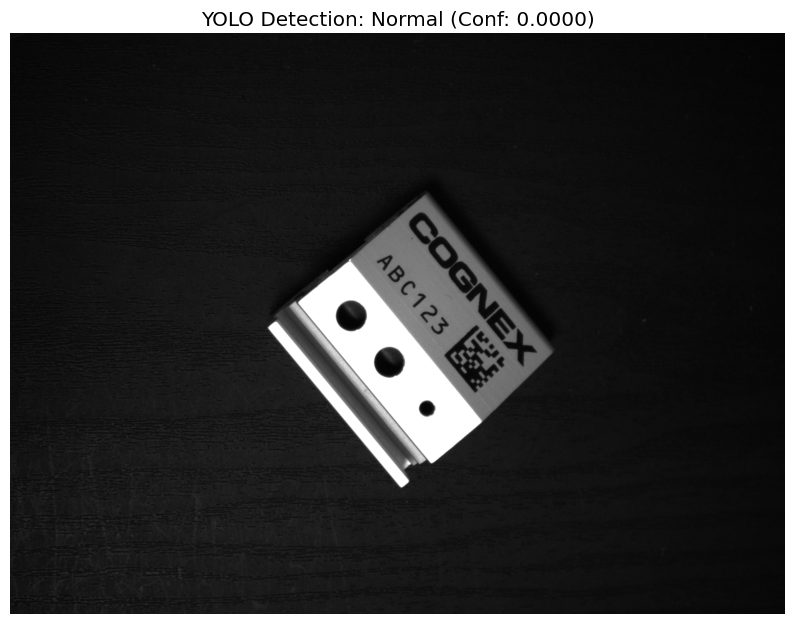

YOLO detector - Defective? False (Confidence: 0.0000)
Anomalib version 2.0.0 is already installed.
Data prepared for anomalib in anomalib_data
Prepared anomalib training data. Would you like to train the anomalib model? (This can take time)
Training anomalib model...


ModuleNotFoundError: No module named 'FrEIA'

In [86]:
import warnings
warnings.filterwarnings('ignore')
import sys
import shutil
from skimage.feature import graycomatrix, graycoprops

# Step 1: Examine the dataset
explore_dataset('defect_detection_dataset')

# Step 2: Test OpenCV defect classifier
test_image_path = os.path.join('defect_detection_dataset/test/defect', os.listdir('defect_detection_dataset/test/defect')[0])
normal_image_path = os.path.join('defect_detection_dataset/test/normal', os.listdir('defect_detection_dataset/test/normal')[0])

# Try basic OpenCV method
result = improved_opencv_defect_classifier(test_image_path, visualize=True)
print(f"Defective? {result[0]} (Score: {result[1]:.4f}, Threshold: {result[2]:.4f})")

# Try normal image for comparison
result = improved_opencv_defect_classifier(normal_image_path, visualize=True)
print(f"Defective? {result[0]} (Score: {result[1]:.4f}, Threshold: {result[2]:.4f})")

# Step 3: Test ensemble OpenCV detector
result = ensemble_opencv_defect_detector(test_image_path, visualize=True)
print(f"Ensemble detector - Defective? {result[0]} (Score: {result[1]:.4f})")

result = ensemble_opencv_defect_detector(normal_image_path, visualize=True)
print(f"Ensemble detector - Defective? {result[0]} (Score: {result[1]:.4f})")

# Step 4: Prepare and train YOLO model
# Note: Training a YOLO model can take significant time
# For demo purposes, you might want to use a pre-trained model
yaml_path = prepare_data_for_yolo('defect_detection_dataset')
print("Prepared YOLO training data. Would you like to train the YOLO model? (This can take time)")
train_yolo = input("Train YOLO model? (y/n): ")

if train_yolo.lower() == 'y':
    print("Training YOLO model...")
    results = train_yolo_model(yaml_path, model_size='n', epochs=10)  # Reduced epochs for demonstration
    model_path = 'trained_models/defect_detector/weights/best.pt'
else:
    print("Skipping YOLO model training.")
    # Use a pre-trained model path if available
    model_path = 'yolov8n.pt'  # Default model, not specialized for defects

# Step 5: Test YOLO detector
if os.path.exists(model_path):
    result = yolo_defect_detector(test_image_path, model_path=model_path, visualize=True)
    print(f"YOLO detector - Defective? {result[0]} (Confidence: {result[1]:.4f})")
    
    result = yolo_defect_detector(normal_image_path, model_path=model_path, visualize=True)
    print(f"YOLO detector - Defective? {result[0]} (Confidence: {result[1]:.4f})")
else:
    print(f"YOLO model not found at {model_path}. Skipping YOLO detection.")

# Step 6: Set up anomalib for anomaly detection
setup_anomalib()

# Step 7: Prepare and train anomalib model
anomalib_data_path = prepare_data_for_anomalib('defect_detection_dataset')
print("Prepared anomalib training data. Would you like to train the anomalib model? (This can take time)")
train_anomalib = input("Train anomalib model? (y/n): ")

if train_anomalib.lower() == 'y':
    print("Training anomalib model...")
    engine, model_path = train_anomalib_model(anomalib_data_path, method="patchcore", image_size=256, batch_size=8)
    
    # Test anomalib detector
    result = anomalib_defect_detector(test_image_path, engine, visualize=True)
    print(f"Anomalib detector - Defective? {result[0]} (Score: {result[1]:.4f}, Threshold: {result[2]:.4f})")
    
    result = anomalib_defect_detector(normal_image_path, engine, visualize=True)
    print(f"Anomalib detector - Defective? {result[0]} (Score: {result[1]:.4f}, Threshold: {result[2]:.4f})")
else:
    print("Skipping anomalib model training.")

# Step 8: Compare all methods
# Note: This requires all the methods to be trained and available
print("Would you like to run a full comparative analysis? (This can take time)")
run_comparison = input("Run comparison? (y/n): ")

if run_comparison.lower() == 'y':
    methods = {
        "OpenCV Basic": lambda img, visualize: improved_opencv_defect_classifier(img, visualize=visualize),
        "OpenCV Ensemble": lambda img, visualize: ensemble_opencv_defect_detector(img, visualize=visualize)
    }
    
    # Add YOLO if available
    if os.path.exists(model_path):
        methods["YOLO"] = lambda img, visualize: yolo_defect_detector(img, model_path=model_path, visualize=visualize)
    
    # Add anomalib if available
    if 'engine' in locals():
        methods["Anomalib (PatchCore)"] = lambda img, visualize: anomalib_defect_detector(img, engine, visualize=visualize)
    
    results = compare_performance(methods, 'defect_detection_dataset/test')
    
    # Print final recommendation
    best_method = max(results.items(), key=lambda x: x[1]['f1'])
    print(f"\nFINAL RECOMMENDATION:")
    print(f"The best performing method is: {best_method[0]} with F1 score of {best_method[1]['f1']:.4f}")
    
    fastest_method = min(results.items(), key=lambda x: x[1]['avg_runtime'])
    print(f"The fastest method is: {fastest_method[0]} with average runtime of {fastest_method[1]['avg_runtime']:.4f} seconds")
else:
    print("Skipping comparative analysis.")

print("\nDefect detection pipeline completed successfully!")